In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pyramid
import math
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from sklearn import metrics
import pandas as pd
from pyramid.arima import auto_arima

np.random.seed(123)

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [2]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    return y

def generate_ts_2(exog):
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    return y
    

In [3]:
Time = np.arange(0,200)

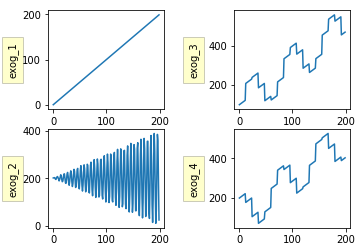

In [4]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)

# Fixing random state for reproducibility
np.random.seed(19680801)

ax1.plot(Time,f_1(Time))
ax1.set_ylabel('exog_1', bbox=box)


ax3.set_ylabel('exog_2',bbox=box)
ax3.plot(Time,f_2(Time))

labelx = -0.3  # axes coords

ax2.plot(Time,f_3(Time,period=12))
ax2.set_ylabel('exog_3', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


ax4.plot(Time,f_4(Time, period=12))
ax4.set_ylabel('exog_4', bbox=box)
ax4.yaxis.set_label_coords(labelx, 0.5)

plt.show()

In [5]:
Exog = np.concatenate([f_1(Time),f_2(Time),f_3(Time, period=12),f_4(Time, period=12)], axis =1)
print (Exog.shape)

(200, 4)


In [6]:
y_1 = generate_ts_1(Exog)
y_2 = generate_ts_2(Exog)

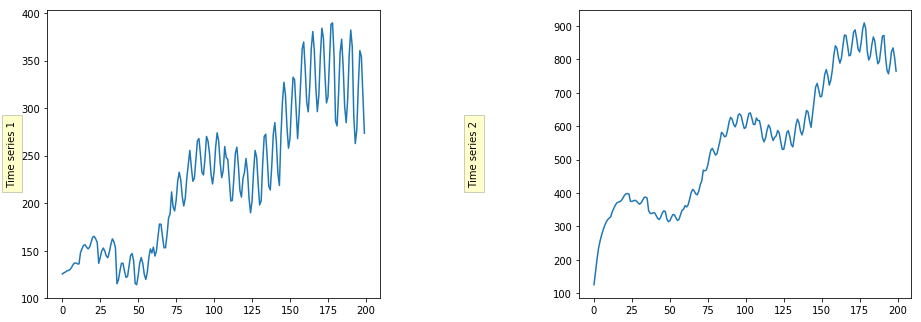

In [7]:
box = dict(facecolor='yellow', pad=5, alpha=0.2)

fig, ((ax1, ax2)) = plt.subplots(1, 2,)
fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)

ax1.plot(Time,y_1)
ax1.set_ylabel('Time series 1', bbox=box)


ax2.plot(Time,y_2)
ax2.set_ylabel('Time series 2', bbox=box)
ax2.yaxis.set_label_coords(labelx, 0.5)


plt.show()

In [8]:
def plot_results(clue,y,forecast):
    plt.figure(figsize=(10,7))
    l1 = plt.plot(Time,y,label = 'observed')
    l2 = plt.plot(Time, forecast, label = 'forecasted')
    observed_test = y[100:]
    forecast_test = forecast[100:]
    plt.title("df{}: MAPE = {}, MAE ={}".format(clue,mean_absolute_percentage_error(observed_test.squeeze(),
                                                                                    forecast_test.squeeze()),
                                               mean_absolute_error(observed_test,forecast_test)))
    plt.axvline(x=100, color = 'red')
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
train_data_1 = y_1[:100]
test_data_1 = y_1[100:]
train_data_2 = y_2[:100]
test_data_2 = y_2[100:]
exog_train = Exog[:100]
exog_test = Exog[100:]

In [10]:
def pyramid_stepwise(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, period = 12, n_periods = 100,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore', information_criterion = 'aic',trend = 'c',
                          suppress_warnings=True,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data, exogenous=Exog_train, start_p=0, start_q=0, max_p=5, max_q=5, m=period,
                          start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                          error_action='ignore',information_criterion = 'oob',trend = 'c',
                          suppress_warnings=True,
                          stepwise=True)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

In [11]:
def pyramid_random_search(train_data=None, Exog_train=None, Exog_test=None,exog_flag = False, 
                          period = 12, n_periods = 100,n_fits = 200, n_jobs = -1, random_state = 42,
                         inf_c = 'oob', trend = 'c'):
    if exog_flag == False:
        model = auto_arima(train_data,start_p=0, start_q=0, max_p=5, max_q=5, m=12,
                    start_P=0, start_Q = 0, n_jobs=n_jobs, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
                    error_action='ignore', information_criterion = 'aic', trend = 'c',
                    suppress_warnings=True, 
                    stepwise=False, random=True, random_state=random_state, n_fits = n_fits)
        in_sample_preds = model.predict_in_sample()
        predictions = model.predict(n_periods=n_periods)
    else:
        model = auto_arima(train_data,exogenous=Exog_train,start_p=0, start_q=0, max_p=5, max_q=5,m=period,
                    start_P=0, start_Q = 0, n_jobs=-1,max_d = 2, max_D = 2, max_P=5, max_Q=5, trace=False,
                    error_action='ignore',  
                    suppress_warnings=True, information_criterion = 'oob', trend = 'c',
                    stepwise=False, random=True, random_state=42, 
                    n_fits=1000)
        in_sample_preds = model.predict_in_sample(exogenous = Exog_train)
        predictions = model.predict(n_periods=n_periods, exogenous = Exog_test)
    return model,in_sample_preds,predictions

## Data frame 1

#### without exogenous:

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(3, 0, 1, 12)   Log Likelihood                -264.797
Date:                            Wed, 11 Jul 2018   AIC                            541.594
Time:                                    17:42:00   BIC                            557.164
Sample:                                         0   HQIC                           547.894
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0356      0.351      0.102      0.919      -0.652       0.723
ar.S.L12       1.9175      0.133   

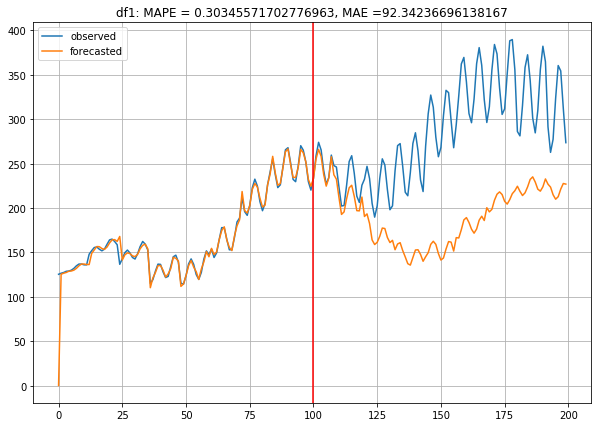

In [12]:
model_1_st, in_sample_preds_1_st,next_validate_1_st = pyramid_stepwise(train_data_1,Exog_train=exog_train,
                                                                       Exog_test=exog_test,
                                                                      exog_flag=False)
print (model_1_st.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_st,next_validate_1_st]))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(4, 1, 0)x(3, 0, 0, 12)   Log Likelihood                -170.748
Date:                            Wed, 11 Jul 2018   AIC                            359.497
Time:                                    17:44:33   BIC                            382.853
Sample:                                         0   HQIC                           368.946
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6252      0.475      7.638      0.000       2.695       4.555
ar.L1         -0.0069      0.150   

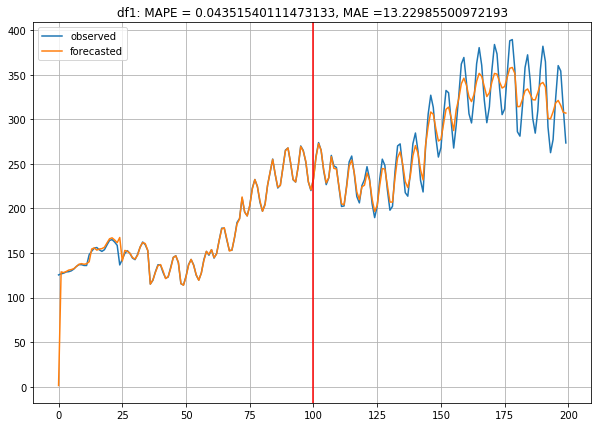

In [13]:
model_1_rs, in_sample_preds_1_rs,next_validate_1_rs = pyramid_random_search(train_data_1,Exog_train=exog_train,Exog_test=exog_test,
                                                                      exog_flag=False,n_fits = 5000)
print (model_1_rs.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_rs,next_validate_1_rs]))

##### with exogenous:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                2909.430
Date:                Wed, 11 Jul 2018   AIC                          -5806.861
Time:                        17:44:34   BIC                          -5791.230
Sample:                             0   HQIC                         -5800.534
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.604e-13   2.21e-14     -7.244      0.000   -2.04e-13   -1.17e-13
x1             0.2500   3.84e-16   6.52e+14      0.000       0.250       0.250
x2             0.2500   1.22e-16   2.05e+15      0.0

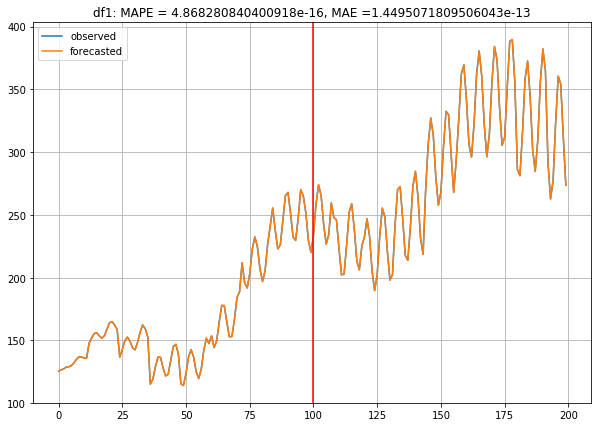

In [14]:
model_1_st_we, in_sample_preds_1_st_we,next_validate_1_st_we = pyramid_stepwise(train_data_1,Exog_train=exog_train,
                                                                                Exog_test=exog_test,
                                                                                  exog_flag=True)
print (model_1_st_we.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_st_we,next_validate_1_st_we]))

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 4)   Log Likelihood                2987.801
Date:                Wed, 11 Jul 2018   AIC                          -5951.602
Time:                        17:44:38   BIC                          -5920.340
Sample:                             0   HQIC                         -5938.949
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1.286e-14   1.02e-15    -12.631      0.000   -1.49e-14   -1.09e-14
x1             0.2500   3.53e-16   7.07e+14      0.000       0.250       0.250
x2             0.2500   4.75e-17   5.26e+15      0.0

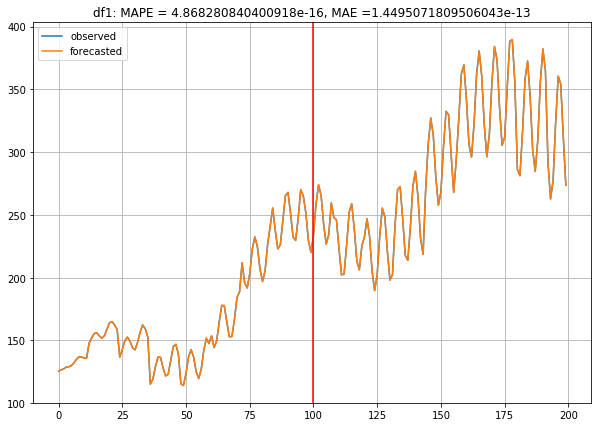

In [15]:
model_1_rs_we, in_sample_preds_1_rs_we,next_validate_1_rs_we = pyramid_random_search(train_data_1,Exog_train=exog_train,
                                                                                     Exog_test=exog_test,
                                                                                      exog_flag=True,n_fits =5000)
print (model_1_rs_we.summary())
plot_results(1,y_1,np.concatenate([in_sample_preds_1_rs_we,next_validate_1_rs_we]))

## Data frame 2

#### without exogenous:

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(4, 1, 0)x(2, 0, 1, 12)   Log Likelihood                -242.959
Date:                            Wed, 11 Jul 2018   AIC                            503.918
Time:                                    17:45:06   BIC                            527.274
Sample:                                         0   HQIC                           513.368
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.012     -0.139      0.889      -0.025       0.022
ar.L1          1.3430      0.073   

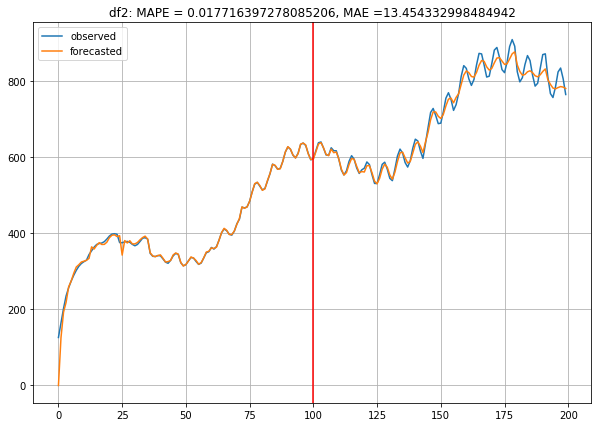

In [16]:
model_2_st, in_sample_preds_2_st,next_validate_2_st = pyramid_stepwise(train_data_2,Exog_train=exog_train,
                                                                       Exog_test=exog_test,
                                                                      exog_flag=False)
print (model_2_st.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_st,next_validate_2_st]))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(3, 1, 2)x(4, 0, 1, 12)   Log Likelihood                -226.555
Date:                            Wed, 11 Jul 2018   AIC                            477.110
Time:                                    17:49:40   BIC                            508.252
Sample:                                         0   HQIC                           489.710
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0144      0.068     -0.211      0.833      -0.147       0.119
ar.L1          2.0557      0.015   

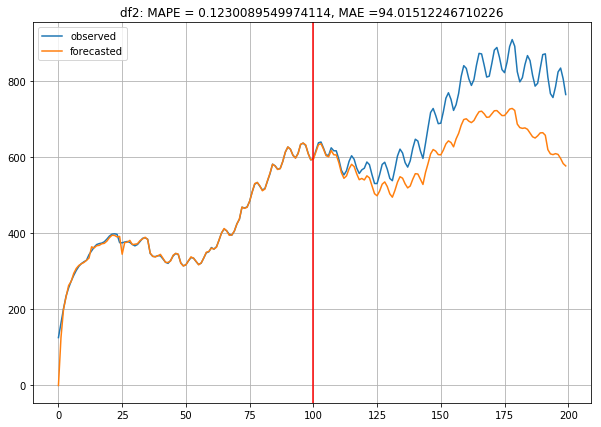

In [17]:
model_2_rs, in_sample_preds_2_rs,next_validate_2_rs = pyramid_random_search(train_data_2,Exog_train=exog_train,
                                                                            Exog_test=exog_test,
                                                                      exog_flag=False,n_fits = 5000)
print (model_2_rs.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_rs,next_validate_2_rs]))

##### with exogenous:

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                        SARIMAX   Log Likelihood                -452.499
Date:                Wed, 11 Jul 2018   AIC                            916.997
Time:                        17:49:42   BIC                            932.628
Sample:                             0   HQIC                           923.323
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     70.6848     24.373      2.900      0.004      22.915     118.455
x1             1.3438      0.182      7.394      0.000       0.988       1.700
x2             0.2067      0.106      1.958      0.0

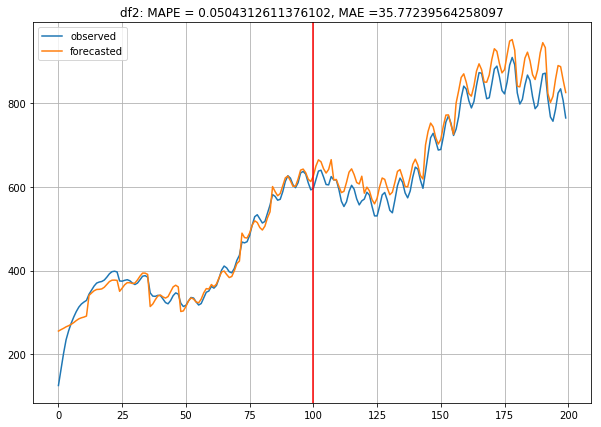

In [18]:
model_2_st_we, in_sample_preds_2_st_we,next_validate_2_st_we = pyramid_stepwise(train_data_2,Exog_train=exog_train,
                                                                                Exog_test=exog_test,
                                                                                  exog_flag=True)
print (model_2_st_we.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_st_we,next_validate_2_st_we]))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 0, 2)x(1, 0, 0, 12)   Log Likelihood                -381.235
Date:                            Wed, 11 Jul 2018   AIC                            780.471
Time:                                    17:54:24   BIC                            803.917
Sample:                                         0   HQIC                           789.960
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     59.1798     20.687      2.861      0.004      18.634      99.726
x1             2.1140      0.246   

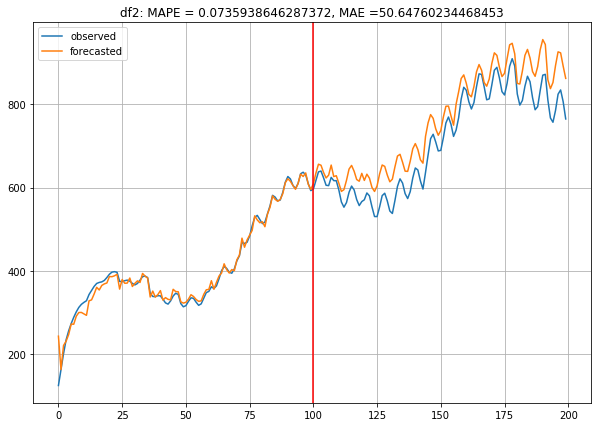

In [19]:
model_2_rs_we, in_sample_preds_2_rs_we,next_validate_2_rs_we = pyramid_random_search(train_data_2,
                                                                    Exog_train=exog_train,Exog_test=exog_test,
                                                                      exog_flag=True,n_fits =5000)
print (model_2_rs_we.summary())
plot_results(2,y_2,np.concatenate([in_sample_preds_2_rs_we,next_validate_2_rs_we]))